In [33]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from lightgbm import LGBMClassifier
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
import numpy as np
# train = pd.read_csv('data.tsv', sep=' ', quotechar='"', escapechar='\\')

In [104]:
all_data = pd.read_csv('data.tsv', sep=' ', quotechar='"', escapechar='\\')
# 1,2,3
s=2

splits =  pd.read_csv("splits.csv",low_memory=True, sep='\t')


In [105]:
test = all_data[all_data.index.isin(splits[f'split_{s}'])]
train = all_data[~all_data.index.isin(splits[f'split_{s}'])]


In [106]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords ,wordnet
from nltk.stem import  WordNetLemmatizer ,PorterStemmer
from collections import Counter 

lemmatiser = WordNetLemmatizer()
ps = PorterStemmer()
def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]

def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    meaningful_words = [lemmatiser.lemmatize( w,get_pos(w)) for w in meaningful_words]
    
    
#     #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [107]:
num_reviews = train["review"].size
# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in range( 0, num_reviews ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( train["review"].iloc[i] ) )

In [108]:
num_reviews = len(test["review"])
clean_test_reviews = [] 

print ("Cleaning and parsing the test set movie reviews...\n")
for i in range(0,num_reviews):
#     if( (i+1) % 1000 == 0 ):
#         print ("Review %d of %d\n" % (i+1, num_reviews))
    clean_review = review_to_words( test["review"].iloc[i] )
    clean_test_reviews.append( clean_review )



Cleaning and parsing the test set movie reviews...



In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(max_df=0.55,max_features=3000,
        strip_accents='unicode', analyzer='word',token_pattern=r'(?u)\b\w{3,}\b',
        ngram_range=(1, 2), use_idf=True,smooth_idf=1,sublinear_tf=True,
        stop_words = 'english',norm='l2')



txt_fitted = tfv.fit(list(clean_train_reviews) + list(clean_test_reviews))
train_data_features = tfv.transform(clean_train_reviews)
test_data_features = tfv.transform(clean_test_reviews)

In [110]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(train_data_features, train["sentiment"] )

roc_auc_score(test.sentiment, clf.predict_proba(test_data_features)[:,1])

0.9282888016250261

In [111]:
%%time
from sklearn.linear_model import LogisticRegressionCV



model = LogisticRegressionCV(tol=0.0001, fit_intercept=True, intercept_scaling=1.0, 
                         cv=2,scoring='roc_auc',n_jobs=2,max_iter=4000,Cs=10,penalty='l2')

model.fit(train_data_features, train["sentiment"])
y_pred=model.predict_proba(test_data_features)[:,1]
output = model.predict(test_data_features)
print(roc_auc_score(test.sentiment, y_pred))

0.9503063757806768
CPU times: user 222 ms, sys: 81.8 ms, total: 304 ms
Wall time: 6.82 s


In [112]:
test_output = test[["sentiment"]].copy()
test_output["prediction"]=output
test_output.to_csv(f"Result_{s}.csv")

In [92]:
clf = LGBMClassifier()
params = {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.1, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 1, 'min_split_gain': 0.04, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 20, 'objective': None, 'random_state': None, 'reg_alpha': 0.01, 'reg_lambda': 0.9, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': 4}
clf.set_params(**params)
# clf.fit(train_data_features, train["sentiment"],eval_metric= 'auc', verbose= 1000)


# roc_auc_score(test.sentiment, clf.predict_proba(test_data_features)[:,1])

0.9468997477286444

In [ ]:

import gc
from skopt.space import Real, Integer
from skopt import gp_minimize

# {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.5684297315960845, 'importance_type': 'split', 'learning_rate': 0.3426509697582906, 'max_depth': 6, 'min_child_samples': 20, 'min_child_weight': 48, 'min_split_gain': 0.3631100008156993, 'n_estimators': 10000, 'n_jobs': -1, 'num_leaves': 37, 'objective': None, 'random_state': None, 'reg_alpha': 0.5820197920751072, 'reg_lambda': 0.5373732294490108, 'silent': True, 'subsample': 0.82081967678168, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': 4}

# space_lgbm  = [Integer(5, 10, name='max_depth'),
#           Integer(30, 40, name='num_leaves'),
#           Integer(1, 10, name='min_child_weight'),
#           Real(0.8, 1, name='subsample'),
#           Real(0.8, 1, name='colsample_bytree'),
#           Real(0.15,0.3,name='learning_rate'),
#           Real(0.2,0.5,name='min_split_gain'),
#           Real(0.01,0.3, name='reg_alpha'),
#           Real(0.5,1,name='reg_lambda')
#          ]
space_lgbm  = [Integer(3, 10, name='max_depth'),
          Integer(20, 30, name='num_leaves'),
          Integer(1, 2, name='min_child_weight'),
          Real(0.9, 1, name='subsample'),
          Real(0.1, 1, name='colsample_bytree'),
          Real(0.01,0.03,name='learning_rate'),
          Real(0.01,0.04,name='min_split_gain'),
          Real(0,0.01, name='reg_alpha'),
          Real(0.9,1,name='reg_lambda')
         ]

def objective_lgbm(values):
    params = {'nthread':4,
            'n_estimators':10000,
            'learning_rate':0.01,
            'num_leaves':values[1],
            'colsample_bytree':values[4],
            'subsample':values[3],
            'max_depth':10,
            'reg_alpha':values[7],
            'reg_lambda':values[8],
            'min_split_gain':values[6],
            'min_child_weight':values[2]}
    clf = LGBMClassifier()
    clf.set_params(**params)
    clf.fit(train_data_features, train["sentiment"],eval_metric= 'auc', verbose= 1000)
    
    print(clf.get_params())
    loss=roc_auc_score(test.sentiment, clf.predict_proba(test_data_features)[:,1])
    print(f'log loss {loss}')
    gc.collect()
    return -loss
def get_lgbm_param():
    res_gp = gp_minimize(objective_lgbm, space_lgbm, n_calls=30,
                         random_state=0,n_random_starts=10)
    print("Best score=%.4f" % res_gp.fun)  
# get_lgbm_param()

In [ ]:
import gc
from skopt.space import Real, Integer
from skopt import gp_minimize
    
    
space  = [Integer(3, 10, name='max_depth'),
          Integer(5, 10, name='num_leaves'),
          Integer(1, 100, name='min_child_weight'),
          Real(1, 100,  name='scale_pos_weight'),
          Real(0, 1, name='subsample'),
          Real(0, 1, name='colsample_bytree'),
          Real(0.01,0.2,name='learning_rate'),
          Real(0.8,1, name='reg_alpha'),
          Real(0.8,1,name='reg_lambda')          
         ]
def objective(values):
    params = {'max_depth': values[0], 
          'num_leaves': values[1], 
          'min_child_weight': 1, 
          'scale_pos_weight': 1,
            'subsample': values[4],
            'colsample_bytree': values[5],
             'metric':'auc',
             'nthread': 4,
             'boosting_type': 'gbdt',
             'objective': 'binary:logistic',
              'reg_alpha':values[7],
              'reg_lambda':values[8],
             'learning_rate':values[6]}
    xgb_model = xgb.XGBClassifier()
    xgb_model.set_params(**params)
    
    xgb_model.fit(train_data_features, train["sentiment"],eval_metric= 'auc', verbose= 1000)
    
    print(xgb_model.get_params())
    loss=roc_auc_score(test.sentiment, xgb_model.predict_proba(test_data_features)[:,1])
    print(f'log loss {loss}')
    gc.collect()
    return -loss
def get_xboost_param():
    res_gp = gp_minimize(objective, space, n_calls=30,
                         random_state=0,n_random_starts=10)
    print("Best score=%.4f" % res_gp.fun)  
# get_xboost_param()
    


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import gc
from skopt.space import Real, Integer
from skopt import gp_minimize

    
    
space  = [Integer(3,10, name='max_depth'),
          Integer(5, 10, name='min_samples_leaf'),
          Real(0.1, 0.9, name='min_samples_split'),
          Integer(2, 100,  name='max_leaf_nodes'),
          Real(0, 10, name='min_impurity_decrease'),         
         ]
def objective(values):
    params = {'max_depth': values[0], 
          'min_samples_leaf': values[1], 
          'min_samples_split': values[2], 
          'max_leaf_nodes': values[3],
            'min_impurity_decrease': values[4]}
    rf = RandomForestClassifier()
    rf.set_params(**params)
    
    rf.fit(train_data_features, train["sentiment"])
    
    print(rf.get_params())
    loss=roc_auc_score(test.sentiment, rf.predict_proba(test_data_features)[:,1])
    print(f'log loss {loss}')
    gc.collect()
    return -loss
def get_rf_param():
    res_gp = gp_minimize(objective, space, n_calls=30,
                         random_state=0,n_random_starts=10)
    print("Best score=%.4f" % res_gp.fun)  
# get_rf_param()
    


In [176]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import pipeline,preprocessing



# We will use logistic regression here..
lr_model = LogisticRegression(max_iter=4000)

# Create the pipeline 
clf = pipeline.Pipeline([('lr', lr_model)])

# parameter grid
param_grid = {'lr__penalty': ['l2','l1'],'lr__C':[ 1.1,1,1.25,1.2],'lr__tol':[0.00001]}

model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc',
                                 verbose=10, n_jobs=2, refit=True, cv=2)

# Fit Grid Search Model
# model.fit(train_data_features, train["sentiment"])  # we can use the full data here but im only using xtrain. 

# loss=roc_auc_score(test.sentiment, model.predict_proba(test_data_features)[:,1])
# print(f'loss is {loss}')
# print("Best score: %0.3f" % model.best_score_)
# print("Best parameters set:")
# best_parameters = model.best_estimator_.get_params()
# for param_name in sorted(param_grid.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1352s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  16 out of  16 | elapsed:    1.3s finished
/home/zztop/.local/share/virtualenvs/word2vec-EFHczPd3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


loss is 0.9514975718821702
Best score: 0.944
Best parameters set:
	lr__C: 1.25
	lr__penalty: 'l2'
	lr__tol: 1e-05


In [ ]:
from sklearn.linear_model import SGDClassifier
import gc
from skopt.space import Real, Integer,Categorical
from skopt import gp_minimize
from sklearn.metrics import roc_auc_score

    
    
space  = [Integer(3,10, name='max_depth'),
#           Categorical('l2', 'elasticnet', name='penalty'),
          Real(0.0001, 0.2, name='learning_rate'),
          Real(0.09, 0.11,  name='l1_ratio'),
          Real(0.00000001,0.1, name='alpha'),         
         ]
def objective(values):
    params = {
        'penalty':'l2',
#           'learning_rate': values[1],
          'l1_ratio': values[2],
            'alpha': values[3]
    }
    rf = SGDClassifier(loss='log',tol=0.00001)
    rf.set_params(**params)
    
    rf.fit(train_data_features, train["sentiment"])
    
    print(rf.get_params())
    loss=roc_auc_score(test.sentiment, rf.predict_proba(test_data_features)[:,1])
    print(f'log loss {loss}')
    gc.collect()
    return -loss
def get_gd_param():
    res_gp = gp_minimize(objective, space, n_calls=30,
                         random_state=0,n_random_starts=10)
    print("Best score=%.4f" % res_gp.fun)  
# get_gd_param()
    


In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn import pipeline,preprocessing
import numpy as np



# We will use logistic regression here..
lr_model = SGDClassifier(loss='log',tol=0.00001)

# Create the pipeline 
clf = pipeline.Pipeline([('lr', lr_model)])

# parameter grid
param_grid = {'lr__l1_ratio': [0.11],'lr__penalty':['elasticnet'],'lr__alpha':[.0002,0.0001,.00001]}

model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc',
                                 verbose=10, n_jobs=2, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(train_data_features, train["sentiment"])  # we can use the full data here but im only using xtrain. 

# loss=roc_auc_score(test.sentiment, model.predict_proba(test_data_features)[:,1])


# print(f'loss is {loss}')
# print("Best score: %0.3f" % model.best_score_)
# print("Best parameters set:")
# best_parameters = model.best_estimator_.get_params()
# for param_name in sorted(param_grid.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:    1.2s remaining:    0.6s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    2.2s finished


loss is 0.9493296217488834
Best score: 0.944
Best parameters set:
	lr__alpha: 0.0001
	lr__l1_ratio: 0.11
	lr__penalty: 'elasticnet'


In [13]:
x=pd.DataFrame({'keys':list(tfv.vocabulary_.keys()),'values':list(tfv.vocabulary_.values())})
x.sort_values(['values'],ascending=[0]).to_csv('myVocab.csv',header=True,index=False)

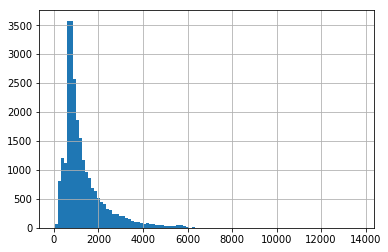

In [14]:
train.review.str.len().hist(bins=100)

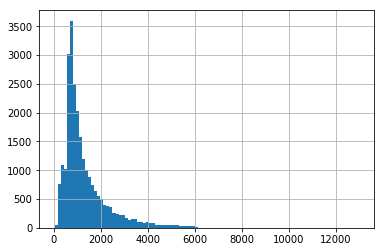

In [15]:
test.review.str.len().hist(bins=100)


Text(0, 0.5, 'True positive rate')

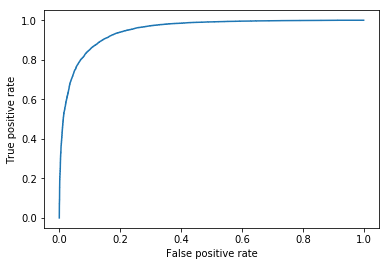

In [120]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib inline

# fpr, tpr, _ = roc_curve(test_data_features.toarray(), y_pred)
fpr, tpr, _ =roc_curve(test.sentiment, y_pred)
# tprs.append(interp(mean_fpr, fpr, tpr))
# tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
# aucs.append(roc_auc)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

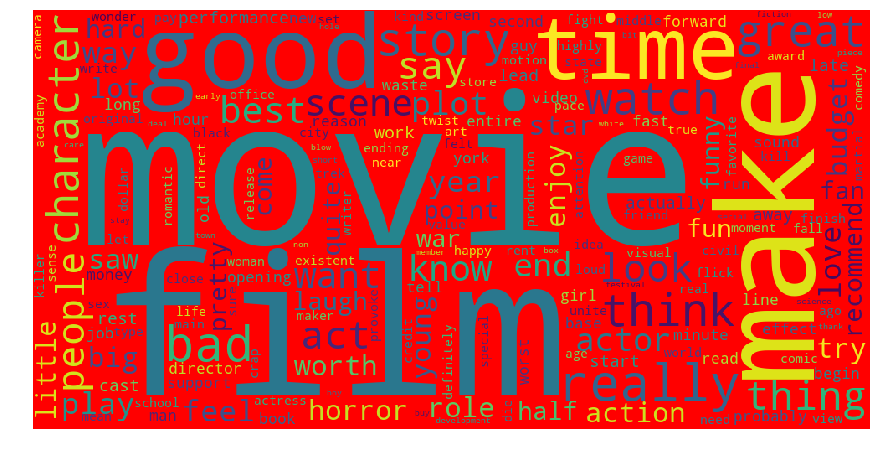

In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

# train_fet=tfv.inverse_transform(train_data_features)
# all_train_words=[]
# for arr in train_fet:
#     for w in arr:
#         all_train_words.append(w) 
        
test_train_words=tfv.inverse_transform(test_data_features+train_data_features)
all_words=[]
for arr in test_train_words:
    for w in arr:
        all_words.append(w) 
    


word_cloud = WordCloud(width = 1000, height = 500, stopwords = STOPWORDS, background_color = 'red').generate(" ".join( list(set(all_words))))

plt.figure(figsize = (15,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()
word_cloud.to_file('train_cloud.png')

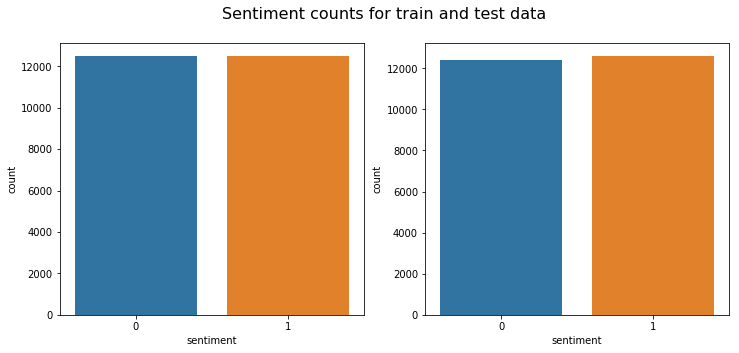

In [17]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
fig.suptitle("Sentiment counts for train and test data", fontsize=16)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(data=pd.DataFrame({'sentiment':(output)}), ax=axes[1],x="sentiment")


(0, 10)

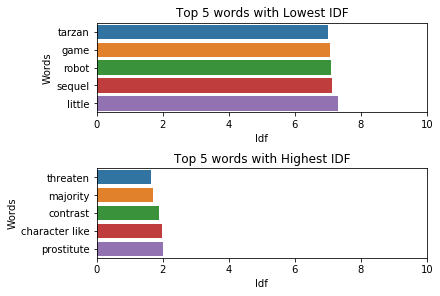

In [85]:
max_value = (test_data_features + train_data_features).max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(tfv.get_feature_names())

x= pd.DataFrame.from_dict(dict(zip(feature_names[sorted_by_tfidf],np.sort(tfv.idf_,))),orient='index', columns=['values'])

# x=pd.DataFrame({'keys':feature_names[sorted_by_tfidf],'values':list(tfv.idf_)})
# x=x.sort_values(['values'],ascending=[0])
# x.tail(50)

fig =plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(2, 1, figure=fig)


ax = fig.add_subplot(gs[0, :])

sns.barplot(y=x.tail(5).index,x=x.tail(5)['values'],ax=ax)
ax.set_ylabel('Words')
ax.set_xlabel('Idf')
ax.set_title('Top 5 words with Lowest IDF')
ax.set_xlim(0,10)

ax = fig.add_subplot(gs[1, :])
sns.barplot(y=x.head(5).index,x=x.head(5)['values'],ax=ax)

ax.set_ylabel('Words')
ax.set_xlabel('Idf')
ax.set_title('Top 5 words with Highest IDF')
ax.set_xlim(0,10)
# for ax in fig.axes:
#     matplotlib.pyplot.sca(ax)
#     plt.xticks(rotation=90)



Text(0.5, 1.0, 'Top 5 words with Highest Word count')

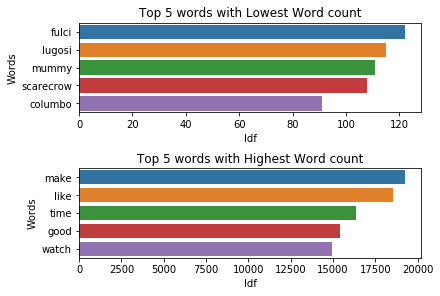

In [84]:
df =pd.DataFrame({'Words':(all_words)})

x=pd.value_counts(df['Words'])



fig =plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(2, 1, figure=fig)


ax = fig.add_subplot(gs[0, :])

sns.barplot(y=x.tail(5).index,x=x.tail(5),ax=ax)

ax.set_ylabel('Words')
ax.set_xlabel('Idf')
ax.set_title('Top 5 words with Lowest Word count')
# ax.set_xlim(0,20000)

ax = fig.add_subplot(gs[1, :])
sns.barplot(y=x.head(5).index,x=x.head(5),ax=ax)

ax.set_ylabel('Words')
ax.set_xlabel('Idf')
ax.set_title('Top 5 words with Highest Word count')
# ax.set_xlim(0,20000)